# DISTILBERT WORKFLOW (UNESCO DATASET)
Status: **DONE**

In [56]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
# from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import torch
# from tensorflow.keras.utils import to_categorical

import importlib

from shared.metrics import compute_classic_metrics, save_evaluation_report
importlib.reload(sys.modules['shared.metrics'])


<module 'shared.metrics' from 'c:\\Users\\mosqu\\personal-projects\\dss_pit\\src\\shared\\metrics.py'>

In [29]:
# LOAD DATASET
df = pd.read_csv("../../../data/unesco/cleaned_dataset.csv")

df.columns = ["text", "label"]

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts())

Dataset shape: (5636, 2)

First 5 rows:
                                                text            label
0  india middle youtube frenzy going get people k...       Conspiracy
1  tweet false reporting shooting people virus ch...  False reporting
2  tweet woman eating delicacy attributing virus ...  False reporting
3  tweet false chain message need containment act...  False reporting
4  hoax alert viral emergency notification fake c...  False reporting

Label distribution:
label
False reporting                 4123
Conspiracy                       966
Fake remedy                      502
Conspiracy, False reporting        5
False Reporting                    3
false reporting                    3
Fake remedy, false reporting       2
False reporting, Fake remedy       1
Conspiracy, Fake remedy            1
Fake remedy, False reporting       1
False reporting, Conspiracy        1
Fake remedy, conspiracy            1
Name: count, dtype: int64


In [30]:
def standardize_label(label):
    """Standardizes the label by lowercasing and replacing variations."""

    # 1. Lowercase for case insensitivity
    label = str(label).lower().strip()

    # 2. Simple replacements/corrections
    if 'false reporting' in label:
        return 'False reporting'
    if 'conspiracy' in label:
        return 'Conspiracy'
    if 'fake remedy' in label:
        return 'Fake remedy'
    return label # Return the original if none of the majors are found

# Apply the standardization function
df['label_cleaned'] = df['label'].apply(standardize_label)

print("--- After Initial Standardization ---")
print(df['label_cleaned'].value_counts())

--- After Initial Standardization ---
label_cleaned
False reporting    4139
Conspiracy          968
Fake remedy         502
nan                  27
Name: count, dtype: int64


In [31]:
df.shape

(5636, 3)

In [32]:
print(f"NaN count before drop: {df['label_cleaned'].isna().sum()}")

# 2. Drop rows where 'text' or 'label_cleaned' is NaN
# We use dropna() with subset to target only the critical columns
df_cleaned = df.dropna(subset=['text', 'label_cleaned'])

# 3. Final verification
print(f"\nNew Dataset shape after drop: {df_cleaned.shape}")
print(f"NaN count after drop: {df_cleaned['label_cleaned'].isna().sum()}")

NaN count before drop: 0

New Dataset shape after drop: (5613, 3)
NaN count after drop: 0


In [33]:
MAJOR_CLASSES = ['False reporting', 'Conspiracy', 'Fake remedy']
DOMINANT_CLASS = 'False reporting'

def consolidate_compound_labels(label):
    """Merges non-major classes into the dominant class."""
    if label in MAJOR_CLASSES:
        return label
    else:
        return DOMINANT_CLASS

# Apply the consolidation function to the new df_cleaned
df_cleaned['Y'] = df_cleaned['label_cleaned'].apply(consolidate_compound_labels)

# Final Result Verification
print("\n--- Final Consolidated Label Distribution (After NaN Drop) ---")
print(df_cleaned['Y'].value_counts())

# Drop intermediate columns
df_final = df_cleaned.drop(columns=['label', 'label_cleaned'])
df_final.columns = ['X', 'Y'] # Rename to X and Y for the model notebook

print(f"\nFinal Ready Dataset Shape: {df_final.shape}")


--- Final Consolidated Label Distribution (After NaN Drop) ---
Y
False reporting    4143
Conspiracy          968
Fake remedy         502
Name: count, dtype: int64

Final Ready Dataset Shape: (5613, 2)


C:\Users\mosqu\AppData\Local\Temp\ipykernel_6888\3730694278.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Y'] = df_cleaned['label_cleaned'].apply(consolidate_compound_labels)


In [34]:
df_final

,X,Y
0,india middle youtube frenzy going get people k...,Conspiracy
1,tweet false reporting shooting people virus ch...,False reporting
2,tweet woman eating delicacy attributing virus ...,False reporting
3,tweet false chain message need containment act...,False reporting
4,hoax alert viral emergency notification fake c...,False reporting
...,...,...
5608,café previne coronavírus é fake news coffee pr...,Fake remedy
5609,número de óbitos bovid é de é fake news number...,False reporting
5610,máscaras de doação da china são contaminadas c...,Conspiracy
5611,máscaras sem qualidade distribuídas pelo minis...,Conspiracy


In [38]:
# LABEL ENCODING

label_list = df_final['Y'].unique().tolist()
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for i, label in enumerate(label_list)}
NUM_CLASSES = len(label_list)

df_final['label'] = df_final['Y'].map(label_to_id)

print(f"Labels mapped to IDs: {label_to_id}")
print(df_final)

Labels mapped to IDs: {'Conspiracy': 0, 'False reporting': 1, 'Fake remedy': 2}
                                                      X                Y  \
0     india middle youtube frenzy going get people k...       Conspiracy   
1     tweet false reporting shooting people virus ch...  False reporting   
2     tweet woman eating delicacy attributing virus ...  False reporting   
3     tweet false chain message need containment act...  False reporting   
4     hoax alert viral emergency notification fake c...  False reporting   
...                                                 ...              ...   
5608  café previne coronavírus é fake news coffee pr...      Fake remedy   
5609  número de óbitos bovid é de é fake news number...  False reporting   
5610  máscaras de doação da china são contaminadas c...       Conspiracy   
5611  máscaras sem qualidade distribuídas pelo minis...       Conspiracy   
5612  vacina da gripe aumenta risco de adoecer coron...  False reporting   

      l

In [39]:
# SPLITTING TO TRAIN/TEST SETS

train_df, test_df = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42,
    stratify=df_final['Y']
)

hf_train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
hf_test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

raw_datasets = DatasetDict({
    'train': hf_train_dataset,
    'test': hf_test_dataset
})

In [41]:
# TOKENIZATION

MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
MAX_SEQUENCE_LENGTH = 128 # Typical maximum length for BERT-style models

def tokenize_function(examples):
    # Truncation ensures max length is respected, padding ensures all inputs have the same length
    return tokenizer(
        examples['X'],
        truncation=True,
        padding='max_length',
        max_length=MAX_SEQUENCE_LENGTH
    )

# Apply tokenization to the entire dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Select the required columns and rename 'label' (for the model)
tokenized_datasets = tokenized_datasets.remove_columns(['X', 'Y'])
tokenized_datasets.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

# Final train and test sets
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

Map: 100%|██████████| 1123/1123 [00:00<00:00, 3708.69 examples/s]


In [43]:
# LOAD PRE-TRAINED MODEL

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    id2label=id_to_label,
    label2id=label_to_id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# CUSTOM METRICS FUNCTION

def compute_metrics(eval_pred):
    """Calculates accuracy and weighted F1 score."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate accuracy
    acc = accuracy_score(labels, predictions)
    
    # Calculate weighted F1 score (good for imbalance)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': acc,
        'f1_weighted': f1,
    }

In [49]:
OUTPUT_DIR = "../../../deep_models/unesco_results/distilbert_results"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,                     # Number of training epochs
    per_device_train_batch_size=16,         # Batch size per device during training
    per_device_eval_batch_size=16,          # Batch size for evaluation
    warmup_steps=500,                       # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                      # Strength of weight decay
    logging_dir='./logs',                   # Directory for storing logs
    logging_steps=50,
    eval_strategy="epoch",            # Evaluate at the end of each epoch
    save_strategy="epoch",                  # Save checkpoint at the end of each epoch
    load_best_model_at_end=True,            # Load the best model found during training
    metric_for_best_model="f1_weighted",    # Optimize for F1 score
)

In [50]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("Starting DistilBERT fine-tuning...")
# Train the model
trainer.train()

print("Training finished. Evaluating on the test set...")

C:\Users\mosqu\AppData\Local\Temp\ipykernel_6888\371486940.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting DistilBERT fine-tuning...


c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.564100,0.540538,0.776492,0.777074
2,0.523100,0.498756,0.803206,0.801736
3,0.286500,0.550265,0.827248,0.823405


c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training finished. Evaluating on the test set...


In [51]:
# Evaluate the best model on the test set
results = trainer.evaluate()

print("\n--- Final Evaluation Results ---")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"Weighted F1 Score: {results['eval_f1_weighted']:.4f}")

# Generate detailed classification report
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = test_dataset['label']

print("\n--- Detailed Classification Report ---")
print(classification_report(true_labels, predictions, target_names=label_list))

# Save the final model and tokenizer
trainer.save_model(f'{OUTPUT_DIR}/final_model')
tokenizer.save_pretrained(f'{OUTPUT_DIR}/final_model')

print(f"\nModel and tokenizer saved to: {OUTPUT_DIR}/final_model")

c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Final Evaluation Results ---
Accuracy: 0.8272
Weighted F1 Score: 0.8234


c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Detailed Classification Report ---
                 precision    recall  f1-score   support

     Conspiracy       0.63      0.54      0.58       194
False reporting       0.87      0.90      0.89       829
    Fake remedy       0.77      0.75      0.76       100

       accuracy                           0.83      1123
      macro avg       0.76      0.73      0.74      1123
   weighted avg       0.82      0.83      0.82      1123


Model and tokenizer saved to: ../../../deep_models/unesco_results/distilbert_results/final_model


In [52]:
# metrics for saving
metrics = compute_classic_metrics(true_labels, predictions)

print("Accuracy:", metrics["accuracy"])
print("F1 Score:", metrics["f1_score"])
print(metrics["report"])

Accuracy: 0.8272484416740873
F1 Score: 0.8234049031174139
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       194
           1       0.87      0.90      0.89       829
           2       0.77      0.75      0.76       100

    accuracy                           0.83      1123
   macro avg       0.76      0.73      0.74      1123
weighted avg       0.82      0.83      0.82      1123



In [54]:
cm = confusion_matrix(true_labels, predictions)
print("Raw confusion matrix:")
print(cm)

Raw confusion matrix:
[[105  86   3]
 [ 61 749  19]
 [  1  24  75]]


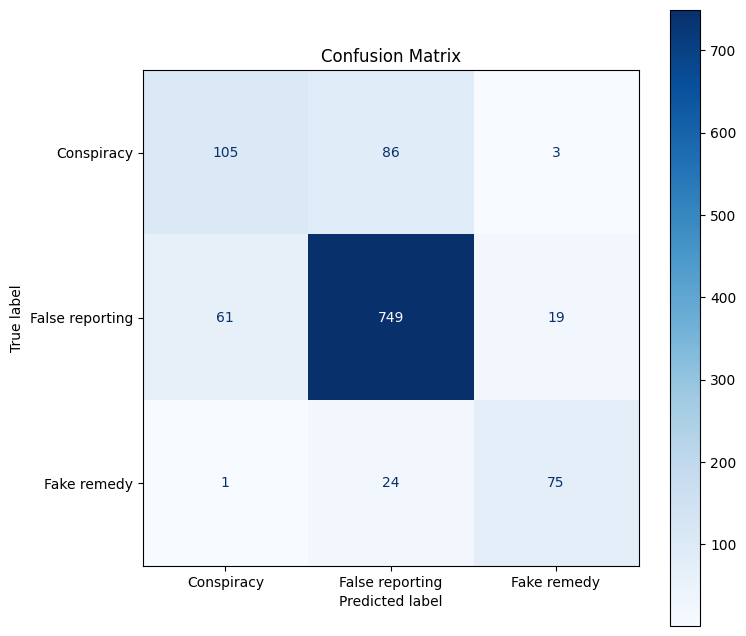

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

# Adjust the plot size and color map
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') # 'd' formats as integer
plt.title("Confusion Matrix")
plt.show()

In [58]:
# SAVING EVAL REPORT
save_evaluation_report(metrics, "../../../deep_models/unesco_results/distilbert_evaluation_report.json")

Evaluation report saved to ../../../deep_models/unesco_results/distilbert_evaluation_report.json
